# Data generator and video deep learning model

This notebook is a will present a reduced version of the work done at the Harvard Medical School in the biomedical informatics department between September 2019 and March 2020. The complet version with more details will be publicly available when the project will be published.


The data consists of cardiac MRI videos with three orientation defining how many heart chambers are observed. Videos were stored as [_dicom_](https://www.dicomlibrary.com/) files containing meta-data about the setting used by the MRI scanner. Files had been filtered and before being stored into a _npy_ format that is less memory consumming and easily handled with the _numpy_ library.

In this file, the use of _data generator_ will be exposed. They have two main advantage :
* The loading of the data is done by batches to avoid memory overflowing. 
In a CPU, a data generator retrieves a _batch_size_ number of files, processes them, and then loads its output into the GPU used for the model optimization. The data-generator class inherits from the _Sequence_ object from Keras to guarantee a proper use of multiprocessing and integration to the pipeline. Dedicated CPUs will prepare a batch of data while another CPU will be "busy" providing it the GPU. **It ensures that the data processing is not the bottleneck factor that slows down the computation.**


* Transformation of the data is done _live_ increasing the possibilities of data augmentation. The class will operate at the **sample scale** (classic data augmentation - shifting, rotating, normalizing) and at the **distribution scale** (uniformization of the labels for regression task or over-sampling for imbalanced classes in binary classification)

The scheme bellow depicts the features that have been implemented :
![Video Data Generator](./Images/DataGenerator.png)


The regression on the age is used as an example.

# Data Loading

In [42]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from DataGenerators import VideoGenerator, TestVideoGenerator
from PreProcessing import PreProcessing
from DataPartitioning import DataPartitioning, get_data_fold
from CustomCallback import R2Callback 
from sklearn.metrics import r2_score, mean_squared_error

In [18]:
# get the labels
age_labels = pickle.load(open('./Data/age_3.p', 'rb'))
# shape of the data : 25 time frames, 150x150 images, greyscale images
input_shape = (25, 150, 150, 1)

# data folder
chambers =  '4ch' #select the MRI view
data_directory = './Videos/Heart/shape'+str(input_shape[0]) +'x'+str(input_shape[1])+'x'+str(input_shape[1])+'-' + chambers +'_3/'

# Make partitionning
partition, labels = DataPartitioning(age_labels, test_fraction= 0.1, val_fraction=0.1,
                                     data_directory = data_directory).make_partition()

batch_size = 16
# preprocessing at the sample scale
prepro = {'normalize': False, 'rotate' : 25, 'shift': 15}
uniform_train = True #make the age disctribution uniform
params_train = {'data_directory' : data_directory,
                'ids' : partition['train'],
                'labels' : labels['train'],
                'balanced' : False,
                'dim' : input_shape,
                'pre_processing_dict' : prepro,
                'batch_size': batch_size,
                'uniform' : uniform_train,
                'shuffle': True}
train_generator = VideoGenerator(**params_train)

prepro = {'normalize': False, 'rotate' : 0, 'shift': 0}
params_val = {'data_directory' : data_directory,
                'ids' : partition['val'],
                'labels' : labels['val'],
                'balanced' : False,
                'dim' : input_shape,
                'pre_processing_dict' : prepro,
                'batch_size': batch_size ,
                'uniform' : False,
                'shuffle': True}

val_generator = VideoGenerator(**params_val)

2018 regression samples from shape25x150x150-4ch_3. Uniform distribution (augmented to 3502 samples)
253 regression samples from shape25x150x150-4ch_3


### Data Augmentation demo

#### Sample scale
Here is an example of the pre-processing applied by the data-generators at the sample level.
The samples are rotated and shifted.

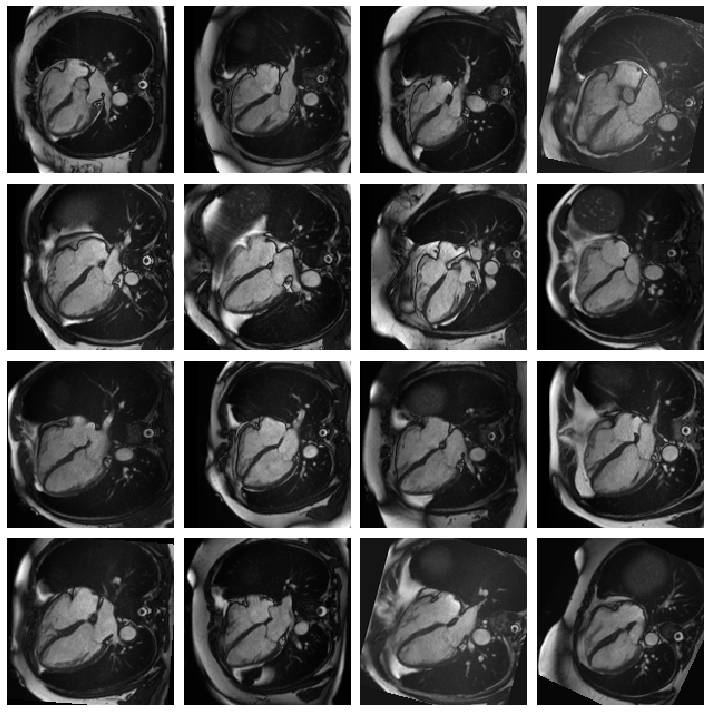

In [17]:
batch_images, batch_labels= train_generator.__getitem__(index=10)
fig, axes = plt.subplots(4,4,figsize = (10,10))

for ax, im, label in zip(axes.flatten(), batch_images, batch_labels):
    ax.imshow(im[0,:,:,0], cmap ='gray')
    ax.axis('off')
fig.tight_layout()
plt.show()

#### Distribution scale
The following plot depicts the tranformation at the distribution scale.
The sample that are less represented in the distribution of the age will be over-sampled to match the most present age.

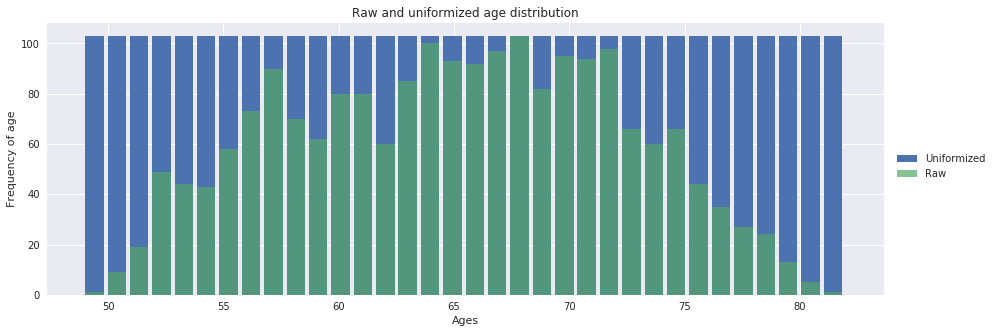

In [19]:
labels_train = train_generator.get_labels() #raw labels
uniform_ids = train_generator.get_IDs() # uniformized ids

fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(15,5))
labels_train.loc[uniform_ids].plot.hist(bins=len(labels_train.unique()),
                                        ax=ax1, width=0.8,
                                       label='Uniformized')
labels_train.plot.hist(bins=len(labels_train.unique()),
                       ax=ax1, width=0.8, alpha= 0.7,
                      label= 'Raw')
fig.legend(loc='center right')
ax1.set_ylabel('Frequency of age')
ax1.set_xlabel('Ages')
ax1.set_title('Raw and uniformized age distribution')
plt.show()

# Model Example

In this model, CNN and RNN will be used as an example of what kind of model could be used on videos.

The model can be split into two disctinc parts. 


First, the spatial information are extracted through a CNN network which weights are optimized among all the time frames. Each image will be encoded into a more compact and meaningfull representation. 

Second, a simple RNN is implemented. It recieves the encoding of the time frames and is optimized to find time-series patterns. The last layer output is compared to the raw age through the root mean square error function. Weights are updated by the Adam optimizer.

![CNN_LSTM_model](./Images/model.png)

In [24]:
import os
import tensorflow as tf
import numpy as np

# NN layers and utils
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Activation, \
                        SpatialDropout2D, Conv2D,Conv1D, MaxPooling2D,TimeDistributed, LSTM
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

set_tensorflow_session()

In [25]:
def set_tensorflow_session():
    """
    Set the tensorflow session
    """
    # CPU
    cpu_count = len(os.sched_getaffinity(0)) # number of available cpus
    tf.config.threading.set_inter_op_parallelism_threads(cpu_count)
    tf.config.threading.set_intra_op_parallelism_threads(cpu_count)

    # GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
            print(e)
def add_default_block(model, kernel_filters, init, reg_lambda):
    """
    Add blocks of two 2D-convolutions
    """
    model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                     kernel_initializer=init,
                                     kernel_regularizer=regularizers.l2(l=reg_lambda))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('selu')))

    model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                     kernel_initializer=init, 
                                     kernel_regularizer=regularizers.l2(l=reg_lambda))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('selu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    return model

def R2_(y_true, y_pred):
    """
    Computes the R squared metric on tensorflow tensors. 
    The functions will be called within the tensorflow session.
    """
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def RMSE(y_true, y_pred):
    """
    Computes the Root Mean Square Error loss on tensorflow tensors. 
    The functions will be called within the tensorflow session.
    """
    return K.sqrt(K.mean(K.square(y_pred - K.cast(y_true, 'float32'))))

In [43]:
# Model's hyper-parameters
L2_reg = regularizers.l2
reg_lambda = 0.001
dropout= 0.3
model = tf.keras.Sequential(name='CNN-LSTM')
initialiser = 'glorot_uniform'


# first (non-default) block
model.add(TimeDistributed(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=L2_reg(l=reg_lambda)),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('selu')))

model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer=initialiser, kernel_regularizer=L2_reg(l=reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('selu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 2nd-5th (default) blocks
model = add_default_block(model, 64,  init=initialiser, reg_lambda=reg_lambda)
model.add(TimeDistributed(SpatialDropout2D(dropout)))
model = add_default_block(model, 128, init=initialiser, reg_lambda=reg_lambda)
model.add(TimeDistributed(SpatialDropout2D(dropout)))
model = add_default_block(model, 256, init=initialiser, reg_lambda=reg_lambda)
model.add(TimeDistributed(SpatialDropout2D(dropout)))
model = add_default_block(model, 512, init=initialiser, reg_lambda=reg_lambda)
model.add(TimeDistributed(Flatten()))


# LSTM output head
model.add(LSTM(128, return_sequences=True, dropout=dropout))
model.add(Flatten())
model.add(Dense(128, activation='selu'))
#output layer
model.add(Dense(1, activation='linear'))

# loading pre-trained wieghts
model.load_weights('./WeightsScores/InitilizationWeights.h5')

In [41]:
model.summary()

Model: "CNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 25, 75, 75, 32)    832       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 25, 75, 75, 32)    128       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 25, 75, 75, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 25, 73, 73, 32)    9248      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 25, 73, 73, 32)    128       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 25, 73, 73, 32)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 25, 36, 36, 32)    0  

In [31]:
lr =1e-3 # learning rate
# Optimizer
adam = Adam(lr = lr, clipnorm = 1.) # force the norm of the gradient to be unitary
# configure the model for training
model.compile(optimizer = adam, loss=RMSE, metrics=[R2_])

# learning rate monitoring
lr_reducing= ReduceLROnPlateau(monitor= 'loss', 
                               factor=0.8, 
                               patience=5,
                               mode='min',
                               verbose=1)
# Custom training monitoring class
# Compute a custom metric, model checkpoint, early stopping and error dealing
output_dir = './WeightsScores'
R2_cb = R2Callback(val_generator, patience=15, restore_best_weights=False,
                         save = True, save_best=True, output_dir= output_dir,
                         restore=False)

Callback : No score file found, first training.


In [ ]:
# Training
logs = model.fit(x=train_generator, verbose=0,
                 use_multiprocessing=True, workers = len(os.sched_getaffinity(0)), 
                 epochs = 200,
                 callbacks = [lr_reducing, R2_cb])

In [28]:
# The TestGenearotor does not apply any data-augmentation. The sampels are in their 
# raw form
test_generator= TestVideoGenerator(data_directory = data_directory,
                                   ids = partition['test'],
                                   labels = labels['test'],
                                   dim = input_shape)
test_predictions = model.predict_generator(test_generator, verbose=1)

Testing Mode - 252 regression samples from shape25x150x150-4ch_3
252/252 [==============================] - 25s 101ms/step


## Model's performance

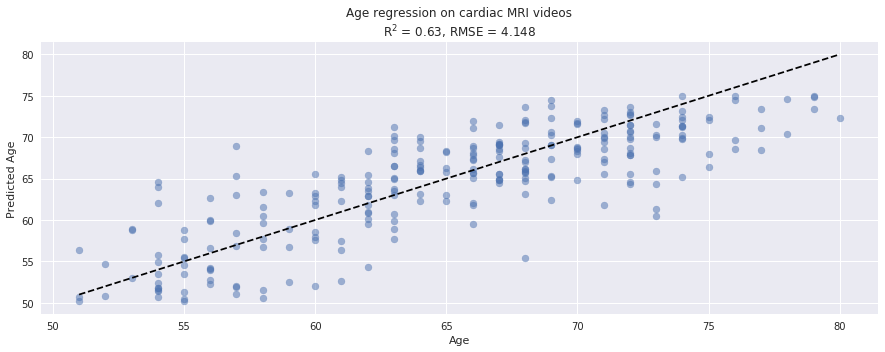

In [37]:
# Compute metric and loss
r_2_test = r2_score(labels['test'], test_predictions)
rmse_test = np.sqrt(mean_squared_error(labels['test'], test_predictions))

# Plotting
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(labels['test'], test_predictions, alpha=0.5)
ax.plot([labels['test'].min(), labels['test'].max()],
        [labels['test'].min(), labels['test'].max()],'k--')
ax.set_ylabel('Predicted Age')
ax.set_xlabel('Age')
ax.set_title('Age regression on cardiac MRI videos\n'\
             'R$^2$ = {}, RMSE = {}'.format(np.round(r_2_test, 3), 
                                            np.round(rmse_test,3)))
plt.show()